In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [2]:
output = True
N = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [4]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)

In [51]:
for dataset in datasets:
    print(dataset, sample_matrices[dataset].shape)

train (5702936, 9)
test (5646474, 9)
model (999999, 9)


In [6]:
@jit(nopython=True)
def triplet_frequencies(matrix, num_symbols=2, pseudocount=0):
    """
    Calculate triplet frequencies of symbols.

    Parameters
    ----------
    matrix : np.array
        N x L matrix containing N sequences of length L.
        Matrix must be mapped to range(0, num_symbols) using
        map_matrix function
    num_symbols : int
        Number of different symbols contained in alignment
    fi : np.array
        Matrix of size L x num_symbols containing relative
        column frequencies of all characters.

    Returns
    -------
    np.array
        Matrix of size L x L x L x num_symbols x num_symbols x num_symbols containing
        relative triplet frequencies of all character combinations
    """
    N, L = matrix.shape
    fijk = pseudocount*np.ones((L, L, L, num_symbols, num_symbols, num_symbols))
    for s in range(N):
        for i in range(L):
            for j in range(L):
                for k in range(L):
                    fijk[i, j, k, matrix[s, i], matrix[s, j], matrix[s, k]] += 1

    # normalize frequencies by the number
    # of sequences
    fijk /= (N+pseudocount)

    return fijk


In [7]:
def compute_cijk(fijk, fij, fi):
    #https://en.wikipedia.org/wiki/Ursell_function
    # fijk - fi fjk - fj fik - fk fij + 2*fi fj fk
    return (fijk
            - (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
               * fij[np.newaxis, :, :, np.newaxis, :, :])
            - (fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis]
               * fij[:, np.newaxis, :, :, np.newaxis, :])
            - (fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :]
                * fij[:, :, np.newaxis, :, :, np.newaxis])
            + (2*fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :]))

In [35]:
def flatten_ijk(cijk):
    L = cijk.shape[0]
    num_symbols = cijk.shape[3]
    flattened = []
    for i in range(L):
        for j in range(i+1, L):
            for k in range(j+1, L):
                for alpha in range(num_symbols):
                    for beta in range(num_symbols):
                        for gamma in range(num_symbols):
                            flattened.append(cijk[i, j, k, alpha, beta, gamma])
    return np.array(flattened)

In [8]:
fijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fijk = triplet_frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fijks[dataset] = fijk

In [9]:
cijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fij = fijs[dataset]
    fi = fis[dataset]
    fijk = fijks[dataset]
    cijk = compute_cijk(fijk, fij, fi)
    cijks[dataset] = cijk

In [10]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
independent_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi, np.zeros_like(Jij)), jump, 1e7, nsample=10)

In [45]:
fi_independent = frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)
fij_independent = pair_frequencies(independent_matrix, num_symbols=q, fi=fi_independent, pseudocount=0.0)
fijk_independent = triplet_frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)

In [46]:
cijk_independent = compute_cijk(fijk_independent, fij_independent, fi_independent)

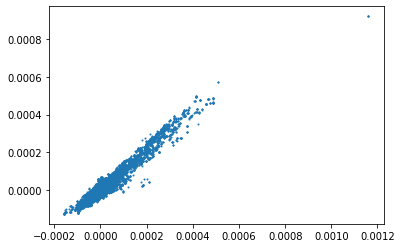

In [47]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijks['train']), 'o', ms=1)

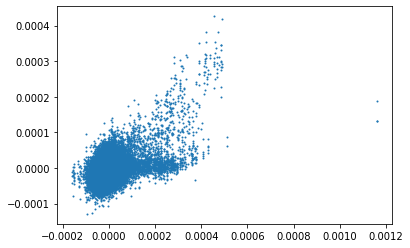

In [42]:
plt.plot(flatten_cijk(cijks['test']), flatten_cijk(cijks['model']), 'o', ms=1)

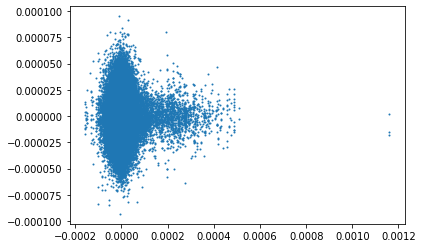

In [44]:
plt.plot(flatten_cijk(cijks['test']), flatten_cijk(cijk_independent), 'o', ms=1)

In [48]:
foldijks = {}
for dataset in datasets:
    fijk = fijks[dataset]
    fi = fis[dataset]
    fold_ijk = fijk / (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
    foldijks[dataset] = fold_ijk

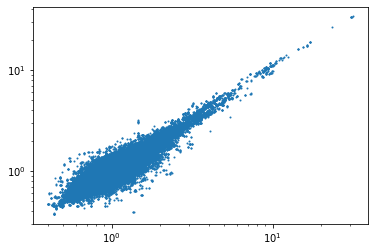

In [49]:
plt.plot(flatten_ijk(foldijks['test']), flatten_ijk(foldijks['train']), 'o', ms=1)
plt.xscale('log')
plt.yscale('log')

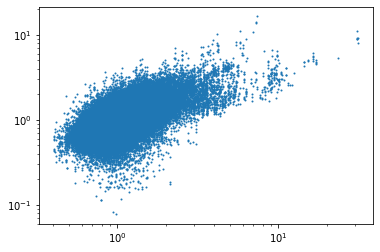

In [50]:
plt.plot(flatten_ijk(foldijks['test']), flatten_ijk(foldijks['model']), 'o', ms=1)
plt.xscale('log')
plt.yscale('log')

In [52]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [60]:
params = np.load('data/train_observables.npz')
fi = params['fi']
cij = params['cij']

In [54]:
params = np.load('data/test_observables.npz')
fi_test = params['fi']
cij_test = params['cij']

In [58]:
params = np.load('data/model_observables.npz')
fi_model = params['fi']
cij_model = params['cij']

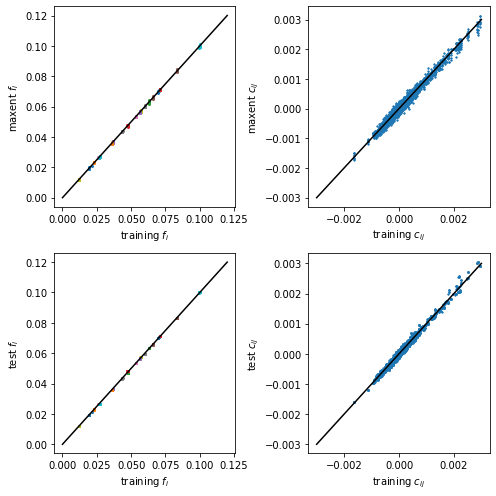

In [73]:
fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2)

for i, (label, fi_) in enumerate([('maxent', fi_model), ('test', fi_test)]):
    ax = axes[i, 0]
    ax.plot(fi, fi_, 'o', ms=2)
    ax.set_xlabel('training $f_i$')
    ax.set_ylabel('%s $f_i$'%label)
    ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.003
for i, (label, cij_) in enumerate([('maxent', cij_model), ('test', cij_test)]):
    ax = axes[i, 1]
    mask = ~np.eye(cij.shape[0], dtype=bool)
    ax.plot(cij[mask].flatten(), cij_[mask].flatten(), 'o', ms=1)
    ax.set_ylabel('%s $c_{ij}$'%label)
    ax.set_xlabel('training $c_{ij}$')
    ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()

In [15]:
import evcouplings.align, evcouplings.couplings

Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)

In [16]:
def JijfrominvC(invC):
    Jij = evcouplings.couplings.reshape_invC_to_4d(invC, N, q)
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

In [17]:
cij_flat = compute_flattened_covariance_matrix(fi, fij)
invC = np.linalg.inv(cij_flat)
Jij_mf = JijfrominvC(invC)
hi_mf = evcouplings.couplings.fields(Jij_mf, fi)

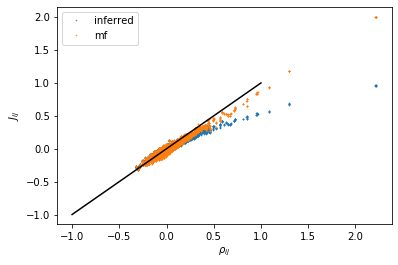

In [26]:
k = N
rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_zerogauge[mask].flatten(), '.', ms=1, label='inferred')
mask = np.abs(Jij_mf) > 1e-5
plt.plot(rhoij[mask].flatten(), -Jij_mf[mask].flatten(), '.', ms=1, label='mf')
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')
plt.xlabel(r'$\rho_{ij}$')
plt.ylabel('$J_{ij}$')
plt.legend()

In [20]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi_mf, -Jij_mf), jump, 1e7, nsample=10)

In [21]:
fi_mf = frequencies(sample_matrix, num_symbols=q)
fij_mf = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_model)
cij_mf = compute_covariance_matrix(fi_mf, fij_mf)

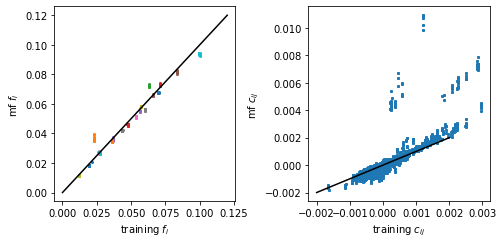

In [22]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
ax.plot(fi, fi_mf, 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('mf $f_i$')
ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.002
ax = axes[1]
mask = ~np.eye(cij.shape[0], dtype=bool)
ax.plot(cij[mask].flatten(), cij_mf[mask].flatten(), 'o', ms=2)
ax.set_ylabel('mf $c_{ij}$')
ax.set_xlabel('training $c_{ij}$')
ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()